In [1]:
import pandas as pd             # data package
import matplotlib.pyplot as plt # graphics 
import datetime as dt
import numpy as np

import requests, io             # internet and input tools  
import zipfile as zf            # zip file tools 
import os  

from numpy.polynomial.polynomial import polyfit

import pyarrow as pa
import pyarrow.parquet as pq

import statsmodels.api as sm
import statsmodels
#import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS
from linearmodels.panel import PanelOLS

import warnings
warnings.filterwarnings("ignore")

C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:10: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import (Categorical, DataFrame, Index, MultiIndex, Panel, Series,


### Preface

This notebook just explores the employment analysis part of the test in the paper ["The Consumption Response to Trade Shocks: Evidence from the US-China Trade War."](http://www.waugheconomics.com/uploads/2/2/5/6/22563786/waugh_consumption.pdf) . This is in Section 5. It mimics many parts of the auto analysis (visualization, tabular representations, and regression analysis). Below I also report the unweighted an weighted regression results.

### Steup for analysis

Just some basic things, bring in the data, make the transformations that we want, etc...

In [2]:
fig_path = "C:\\github\\expenditure_tradeshocks\\figures"

This is the cell below to change if you want to toggle between all employment and only goods producing employment.

In [3]:
file_path = os.getcwd()

#trade_county = pq.read_table(file_path + "\\data\\trade_employment_goods.parquet").to_pandas()

trade_county = pq.read_table(file_path + "\\data\\trade_employment_all.parquet").to_pandas()

In [4]:
trade_county["time"] = pd.to_datetime(trade_county.time)

trade_county.set_index(["area_fips", "time"],inplace = True)

In [5]:
trade_county.head(30)

total_exp_pc  china_exp_pc    tariff  emplvl_2017  \
area_fips time                                                            
10001     2017-01-01    512.529185     53.382853  1.172229       2843.0   
          2017-02-01    492.604071     43.723710  1.172278       2843.0   
          2017-03-01    560.679984     37.347986  1.172365       2843.0   
          2017-04-01    499.471573     29.463467  1.172366       2843.0   
          2017-05-01    508.584288     30.009914  1.172366       2843.0   
          2017-06-01    499.350776     26.428918  1.172366       2843.0   
          2017-07-01    482.861116     28.199912  1.172365       2843.0   
          2017-08-01    500.243692     30.920545  1.172365       2843.0   
          2017-09-01    485.835551     40.123629  1.172365       2843.0   
          2017-10-01    559.828124     69.302723  1.172365       2843.0   
          2017-11-01    561.543549     68.431336  1.172365       2843.0   
          2017-12-01    545.184928     55.044490  1.172365       2843.0   
          2018-01-01    508.771439     44.837035  1.172287       2843.0   
          2018-02-01    507.639236     40.387392  1.172372       2843.0   
          2018-03-01    578.638456     39.261744  1.172364       2843.0   
          2018-04-01    550.940726     32.838192  1.618647       2843.0   
          2018-05-01    570.086178     30.267253  1.618648       2843.0   
          2018-06-01    550.233815     25.724372  1.618648       2843.0   
          2018-07-01    517.268058     22.709404  2.658051       2843.0   
          2018-08-01    538.203378     22.653503  2.658051       2843.0   
          2018-09-01    503.607799     18.887739  2.671780       2843.0   
          2018-10-01    555.839818     22.324031  2.931847       2843.0   
          2018-11-01    548.307689     22.488479  2.851468       2843.0   
          2018-12-01    518.410176     21.394456  2.851468       2843.0   
          2019-01-01    521.269401     27.129946  2.849199       2843.0   
          2019-02-01    498.847293     31.295510  2.848524       2843.0   
          2019-03-01    566.896475     33.364345  2.848460       2843.0   
          2019-04-01    534.509388     25.752972  2.848459       2843.0   
          2019-05-01    546.931214     31.870304  2.848458       2843.0   
          2019-06-01    520.400377     35.623348  2.848457       2843.0   

                       fips  total_employment  emply_month  
area_fips time                                              
10001     2017-01-01  10001           29514.0          0.0  
          2017-02-01  10001           29514.0          0.0  
          2017-03-01  10001           29514.0          0.0  
          2017-04-01  10001           29514.0          0.0  
          2017-05-01  10001           29514.0          0.0  
          2017-06-01  10001           29514.0          0.0  
          2017-07-01  10001           29514.0          0.0  
          2017-08-01  10001           29514.0          0.0  
          2017-09-01  10001           29514.0          0.0  
          2017-10-01  10001           29514.0          0.0  
          2017-11-01  10001           29514.0          0.0  
          2017-12-01  10001           29514.0          0.0  
          2018-01-01  10001           29514.0          0.0  
          2018-02-01  10001           29514.0          0.0  
          2018-03-01  10001           29514.0          0.0  
          2018-04-01  10001           29514.0          0.0  
          2018-05-01  10001           29514.0          0.0  
          2018-06-01  10001           29514.0          0.0  
          2018-07-01  10001           29514.0          0.0  
          2018-08-01  10001           29514.0          0.0  
          2018-09-01  10001           29514.0          0.0  
          2018-10-01  10001           29514.0          0.0  
          2018-11-01  10001           29514.0          0.0  
          2018-12-01  10001           29514.0          0.0  
          2019-01-01  10001        

In [6]:
trade_county["log_tariff"] = np.log(1+.01*trade_county["tariff"])

trade_county["log_exp_total"] = np.log(trade_county["total_exp_pc"]).replace(-np.inf, np.nan)

trade_county["log_exp_china"] = np.log(trade_county["china_exp_pc"]).replace(-np.inf, np.nan)

trade_county["log_employment"] = np.log(trade_county["emply_month"]).replace(-np.inf, np.nan)

trade_county["const"] = 1

In [7]:
trade_county.reset_index(inplace = True)

trade_county.rename({"area_fips": "GEOFIPS"},axis = 1, inplace = True)

trade_county["state_fips"] = trade_county["GEOFIPS"].astype(str).str[0:2]

trade_county["GEOFIPS"] = trade_county["GEOFIPS"].astype(int)

In [8]:
trade_county.set_index(["GEOFIPS", "time"], inplace = True)

In [9]:
trade_county.head()

total_exp_pc  china_exp_pc    tariff  emplvl_2017   fips  \
GEOFIPS time                                                                   
10001   2017-01-01    512.529185     53.382853  1.172229       2843.0  10001   
        2017-02-01    492.604071     43.723710  1.172278       2843.0  10001   
        2017-03-01    560.679984     37.347986  1.172365       2843.0  10001   
        2017-04-01    499.471573     29.463467  1.172366       2843.0  10001   
        2017-05-01    508.584288     30.009914  1.172366       2843.0  10001   

                    total_employment  emply_month  log_tariff  log_exp_total  \
GEOFIPS time                                                                   
10001   2017-01-01           29514.0          0.0    0.011654       6.239358   
        2017-02-01           29514.0          0.0    0.011655       6.199706   
        2017-03-01           29514.0          0.0    0.011655       6.329150   
        2017-04-01           29514.0          0.0    0.011655       6.213551   
        2017-05-01           29514.0          0.0    0.011655       6.231631   

                    log_exp_china  log_employment  const state_fips  
GEOFIPS time                                                         
10001   2017-01-01       3.977490             NaN      1         10  
        2017-02-01       3.777891             NaN      1         10  
        2017-03-01       3.620279             NaN      1         10  
        2017-04-01       3.383151             NaN      1         10  
        2017-05-01       3.401528             NaN      1         10

### Simple Cuts of Employment Data by Tariff Exposure

Here is the strategy. First, compute the quantiles of tariff exposure for each county. Then compute year over year sales growth for each county. Note that since this is in growth rates, this takes out any county level "fixed effect" and removes any seasonal component. 

Then we will simply plot year over year employment growth, for the (mean or median) county in a particular part of the distribution of tariff exposure.

This stuff is not reported in the paper, but is here to mimic the results for the autos.

Note the stuff below will also replicate the summary statistics in the paper.

In [10]:
# First take growth rates

# note , I'm a bit confused about why the sorting,
# here is that because of some missing values, the resulting dateframe from the 
# first operation may be out of place, so we need to resort things to make sure that
# the time difference is correct.

trade_county["tariff_change"] = trade_county.groupby(["GEOFIPS"]).tariff.diff(12)

trade_county.sort_values(["GEOFIPS", "time"], inplace = True)

trade_county["log_tariff_change"] = trade_county.groupby(["GEOFIPS"]).log_tariff.diff(12)

trade_county.sort_values(["GEOFIPS", "time"], inplace = True)

trade_county["employment_growth"] = trade_county.groupby(["GEOFIPS"]).log_employment.diff(12)

trade_county.sort_values(["GEOFIPS", "time"], inplace = True)

In [11]:
# Then what we will do is look at the change in the taiff distribution...

exposure = pd.qcut(trade_county.xs('2018-12-1', level=1).tariff_change, 4 ,labels = False)

#median_exposure = pd.qcut(trade_county.xs('2018-12-1', level=1).alt_tariff, 5 ,labels = False)

In [12]:
most_exposed = exposure[exposure == 3].index.tolist()

mid_group = exposure.isin([1,2])

med_exposed = exposure[mid_group].index.tolist()

least_exposed = exposure[exposure == 0].index.tolist()

trade_county.xs('2018-12-1', level=1).tariff_change.mean()


1.5371274693531065

In [13]:
print("Tariff Change-Most:", round(trade_county.loc[most_exposed].xs('2018-12-1', level=1).tariff_change.mean(),2))
print("Tariff Change-Midl:", round(trade_county.loc[med_exposed].xs('2018-12-1', level=1).tariff_change.mean(),2))
print("Tariff Change-Lest:",round(trade_county.loc[least_exposed].xs('2018-12-1', level=1).tariff_change.mean(),2))
print("Tariff Change-Mean:", round(trade_county.xs('2018-12-1', level=1).tariff_change.mean(),2))

Tariff Change-Most: 3.92
Tariff Change-Midl: 1.04
Tariff Change-Lest: 0.15
Tariff Change-Mean: 1.54


In [14]:
print("Chinese Exports 2017, (Most, Middle, Least, Mean)")

measure = "china_exp_pc"

print(round(trade_county.loc[most_exposed].groupby("time").agg({measure :"mean"}).loc["2017"].sum()[0],0))

print(round(trade_county.loc[med_exposed].groupby("time").agg({measure :"mean"}).loc["2017"].sum()[0],0))

print(round(trade_county.loc[least_exposed].groupby("time").agg({measure :"mean"}).loc["2017"].sum()[0],0))

print(round(trade_county.groupby("time").agg({measure:"mean"}).loc["2017"].sum()[0],0))

Chinese Exports 2017, (Most, Middle, Least, Mean)
3720.0
1321.0
372.0
1805.0


In [15]:
print("Annual Employment, (Most, Middle, Least, Mean)")

print(round(trade_county.loc[most_exposed].groupby("time").agg({"emply_month":"mean"}).loc["2017"].mean()[0],0))

print(round(trade_county.loc[med_exposed].groupby("time").agg({"emply_month":"mean"}).loc["2017"].mean()[0],0))

print(round(trade_county.loc[least_exposed].groupby("time").agg({"emply_month":"mean"}).loc["2017"].mean()[0],0))

print(round(trade_county.groupby("time").agg({"emply_month":"mean"}).loc["2017"].mean()[0],0))

Annual Employment, (Most, Middle, Least, Mean)
11631.0
55941.0
29668.0
38144.0


Now we will plot a comparision between those who are most exposed and those whoe are the least exposed (in terms of changes). This is basically the difference in difference by visualization.

In [16]:
empl_most = trade_county.loc[most_exposed].groupby("time").agg({"employment_growth":"mean"})

empl_least = trade_county.loc[least_exposed].groupby("time").agg({"employment_growth":"mean"})

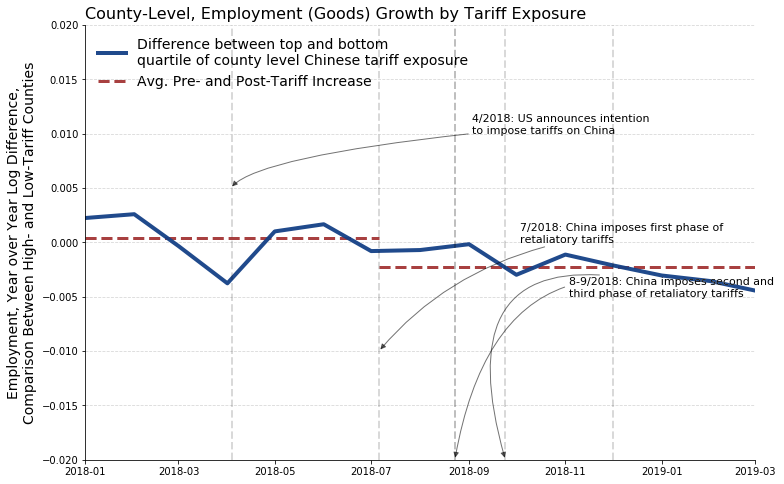

In [17]:
fig, ax = plt.subplots(figsize = (12,8))

mike_blue = tuple(np.array([20, 64, 134]) / 255)

ax.plot((empl_most - empl_least), alpha = 0.95, color = mike_blue, linewidth = 4, 
        label = 'Difference between top and bottom\nquartile of county level Chinese tariff exposure')

#ax.plot(, alpha = 0.95, color = mike_blue , linewidth = 4, 
#        label = 'Bottom Quantile of Chinese Tariff Exposure Counties')

ax.set_ylim(-0.02,0.02)

ax.set_xlim(dt.datetime(2018,1,1),dt.datetime(2019,3,1))

ax.spines["right"].set_visible(False)

ax.spines["top"].set_visible(False)

ax.yaxis.grid(alpha= 0.5, linestyle= "--")

ax.set_ylabel("Employment, Year over Year Log Difference,\nComparison Between High- and Low-Tariff Counties", fontsize = 14)

ax.hlines((empl_most - empl_least).loc[:"2018-07-01"].mean().iloc[0],
          dt.datetime(2018,1,1),dt.datetime(2018,7,6),
           linewidth = 3, color = 'darkred', alpha =0.75, linestyle = "--")

ax.hlines((empl_most - empl_least).loc["2018-08-01":].mean().iloc[0],
          dt.datetime(2018,7,6),dt.datetime(2019,3,1),
           linewidth = 3, color = 'darkred', alpha =0.75, linestyle = "--", label = "Avg. Pre- and Post-Tariff Increase")

ax.axvline(dt.datetime(2018,4,4), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

ax.axvline(dt.datetime(2018,7,6), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

ax.axvline(dt.datetime(2018,8,23), linewidth = 2, ls = "--", color = 'k', alpha =0.25)

ax.axvline(dt.datetime(2018,9,24), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

ax.axvline(dt.datetime(2018,12,1), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

ax.legend(loc = 0, frameon  = False, fontsize = 14)

ax.set_title("County-Level, Employment (Goods) Growth by Tariff Exposure", fontsize = 16, loc= "left" )

##############################################################################################

ax.annotate(
    "4/2018: US announces intention\nto impose tariffs on China", 
    xy=(dt.datetime(2018,4,3), 0.005), # This is where we point at...
    xycoords="data", # Not exactly sure about this
    xytext=(dt.datetime(2018,9,3), 0.01), # This is about where the text is
    horizontalalignment="left", # How the text is alined
    arrowprops={
        "arrowstyle": "-|>", # This is stuff about the arrow
        "connectionstyle": "angle3,angleA=5,angleB=50",
        "color": "black",
        "alpha": 0.55
    },
    fontsize=11,
)

##############################################################################################

ax.annotate(
    "7/2018: China imposes first phase of\nretaliatory tariffs", 
    xy=(dt.datetime(2018,7,6), -0.01), # This is where we point at...
    xycoords="data", # Not exactly sure about this
    xytext=(dt.datetime(2018,10,3), 0.0), # This is about where the text is
    horizontalalignment="left", # How the text is alined
    arrowprops={
        "arrowstyle": "-|>", # This is stuff about the arrow
        "connectionstyle": "angle3,angleA=5,angleB=50",
        "color": "black",
        "alpha": 0.55
    },
    fontsize=11,
)

###################################################################################

ax.annotate(
    "8-9/2018: China imposes second and \nthird phase of retaliatory tariffs", 
    xy=(dt.datetime(2018,8,23), -0.02), color='white',# This is where we point at...
    xycoords="data", # Not exactly sure about this
    xytext=(dt.datetime(2018,11,3), -0.005), # This is about where the text is
    horizontalalignment="left", # How the text is alined
    arrowprops={
        "arrowstyle": "-|>", # This is stuff about the arrow
        "connectionstyle": "angle3,angleA=345,angleB=80",
        "color": "black",
        "alpha": 0.55
    },
    fontsize=11,
)

###################################################################################

ax.annotate(
    "8-9/2018: China imposes second and \nthird phase of retaliatory tariffs", 
    xy=(dt.datetime(2018,9,24), -0.02), # This is where we point at...
    xycoords="data", # Not exactly sure about this
    xytext=(dt.datetime(2018,11,3), -0.005), # This is about where the text is
    horizontalalignment="left", # How the text is alined
    arrowprops={
        "arrowstyle": "-|>", # This is stuff about the arrow
        "connectionstyle": "angle3,angleA=345,angleB=286",
        "color": "black",
        "alpha": 0.55
    },
    fontsize=11,
)

##############################################################################################

#plt.savefig(fig_path + "\\simple_employment_county_all.pdf", bbox_inches = "tight", dip = 3600)

plt.show()

Then this will do the tabular representation using stuff before and after the first phase of the tradewar.

In [18]:
idx = pd.IndexSlice

me_mean = trade_county.loc[most_exposed].loc[idx[:,"2018-01-01":"2018-06-01"],:].employment_growth.mean()

me_nobs = trade_county.loc[most_exposed].loc[idx[:,"2018-01-01":"2018-06-01"],:].employment_growth.notnull().sum()

me_se = trade_county.loc[most_exposed].loc[idx[:,"2018-01-01":"2018-06-01"],:].employment_growth.std()/me_nobs**0.5


le_mean = trade_county.loc[least_exposed].loc[idx[:,"2018-01-01":"2018-06-01"],:].employment_growth.mean()

le_nobs = trade_county.loc[least_exposed].loc[idx[:,"2018-01-01":"2018-06-01"],:].employment_growth.notnull().sum()

le_se = trade_county.loc[least_exposed].loc[idx[:,"2018-01-01":"2018-06-01"],:].employment_growth.std()/me_nobs**0.5

print(round(me_mean,4), round(me_se,3), me_nobs)
print(round(le_mean,4), round(le_se,3), le_nobs)

0.0106 0.001 4683
0.01 0.001 4620


In [19]:
idx = pd.IndexSlice

me_mean = trade_county.loc[most_exposed].loc[idx[:,"2018-07-01":],:].employment_growth.mean()

me_nobs = trade_county.loc[most_exposed].loc[idx[:,"2018-07-01":],:].employment_growth.notnull().sum()

me_se = trade_county.loc[most_exposed].loc[idx[:,"2018-07-01":],:].employment_growth.std()/me_nobs**0.5


le_mean = trade_county.loc[least_exposed].loc[idx[:,"2018-07-01":],:].employment_growth.mean()

le_nobs = trade_county.loc[least_exposed].loc[idx[:,"2018-07-01":],:].employment_growth.notnull().sum()

le_se = trade_county.loc[least_exposed].loc[idx[:,"2018-07-01":],:].employment_growth.std()/me_nobs**0.5

print(round(me_mean,4), round(me_se,3), me_nobs)
print(round(le_mean,4), round(le_se,3), le_nobs)

0.0095 0.001 7038
0.0116 0.001 6948


Not discussed in the paper, but what this looks like is that both looked relativly the same before the start of it interms of employment growth. But after the first phase, the least exposed did really well (this is consistent with a rocking US economy) but those most exposed did relativly poorly. But growth here is still positive. 

### Regression Analysis

This will walk through the results using employment data. The first set are the main (weighted results). The next set are the unweighted results. Numbers may not exactly match up to what is in the paper as some rounding is occuring. 

In [20]:
trade_county.columns

Index(['total_exp_pc', 'china_exp_pc', 'tariff', 'emplvl_2017', 'fips',
       'total_employment', 'emply_month', 'log_tariff', 'log_exp_total',
       'log_exp_china', 'log_employment', 'const', 'state_fips',
       'tariff_change', 'log_tariff_change', 'employment_growth'],
      dtype='object')

### Weighted Results

#### Change on Change, no time or fixed effects

In [21]:
all_vars = ["const", "log_tariff_change", 'employment_growth','total_employment']

dataset = trade_county[all_vars].loc[idx[:,"2018-01-01":"2019-03-01"],:]

exog_vars = ["const","log_tariff_change"]

weights = dataset['total_employment'].to_frame()
# I fought with this alot. the weights shape needs to exaclty match up
# with the dataframe for which the estimation is done. So what I do is
# slice as above, then let PanelOLS drop things when there are missing 
# observations

weights.replace(to_replace = 0, value = 0.001,inplace = True)
# Some countys because of there size and how the QCEW deals with stuff, there are is zero.
# PanelOLS does not like 0 weight, so this the the work around. It does not matter. 

mod = PanelOLS(dataset.employment_growth, dataset[exog_vars], weights = weights)

fe_res = mod.fit(cov_type='clustered')

print(fe_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:      employment_growth   R-squared:                        0.0049
Estimator:                   PanelOLS   R-squared (Between):              0.0050
No. Observations:               47061   R-squared (Within):               0.0049
Date:                Fri, Oct 04 2019   R-squared (Overall):              0.0049
Time:                        06:34:59   Log-likelihood                 1.155e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   3.116e+04
Entities:                        3145   P-value                           0.0000
Avg Obs:                       14.964   Distribution:                 F(1,47059)
Min Obs:                       3.0000                                           
Max Obs:                       15.000   F-statistic (robust):             111.81
                            

#### Change on Change, now with just the time effect.

In [22]:
all_vars = ["const", "log_tariff_change", 'employment_growth','total_employment']

dataset = trade_county[all_vars].loc[idx[:,"2018-01-01":"2019-03-01"],:]

exog_vars = ["const","log_tariff_change"]

weights = dataset['total_employment'].to_frame()
# I fought with this alot. the weights shape needs to exaclty match up
# with the dataframe for which the estimation is done. So what I do is
# slice as above, then let PanelOLS drop things when there are missing 
# observations

weights.replace(to_replace = 0, value = 0.001,inplace = True)
# Some countys because of there size and how the QCEW deals with stuff, there are is zero.
# PanelOLS does not like 0 weight, so this the the work around. It does not matter. 

mod = PanelOLS(dataset.employment_growth, dataset[exog_vars], weights = weights, time_effects = True)

fe_res = mod.fit(cov_type='clustered')

print(fe_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:      employment_growth   R-squared:                        0.0054
Estimator:                   PanelOLS   R-squared (Between):              0.0053
No. Observations:               47061   R-squared (Within):               0.0028
Date:                Fri, Oct 04 2019   R-squared (Overall):              0.0046
Time:                        06:35:01   Log-likelihood                 1.156e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   3.127e+04
Entities:                        3145   P-value                           0.0000
Avg Obs:                       14.964   Distribution:                 F(1,47045)
Min Obs:                       3.0000                                           
Max Obs:                       15.000   F-statistic (robust):             124.89
                            

#### Change on Change, time effects and county-level fixed effects

In [23]:
all_vars = ["const", "log_tariff_change", 'employment_growth','total_employment']

dataset = trade_county[all_vars].loc[idx[:,"2018-01-01":"2019-03-01"],:]

exog_vars = ["const","log_tariff_change"]

weights = dataset['total_employment'].to_frame()
# I fought with this alot. the weights shape needs to exaclty match up
# with the dataframe for which the estimation is done. So what I do is
# slice as above, then let PanelOLS drop things when there are missing 
# observations

weights.replace(to_replace = 0, value = 0.001,inplace = True)
# Some countys because of there size and how the QCEW deals with stuff, there are is zero.
# PanelOLS does not like 0 weight, so this the the work around. It does not matter. 

mod = PanelOLS(dataset.employment_growth, dataset[exog_vars], weights = weights, entity_effects=True, 
               time_effects = True)

fe_res = mod.fit(cov_type='clustered')

print(fe_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:      employment_growth   R-squared:                        0.0057
Estimator:                   PanelOLS   R-squared (Between):              0.0051
No. Observations:               47061   R-squared (Within):               0.0045
Date:                Fri, Oct 04 2019   R-squared (Overall):              0.0049
Time:                        06:35:03   Log-likelihood                 1.462e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   8.516e+04
Entities:                        3145   P-value                           0.0000
Avg Obs:                       14.964   Distribution:                 F(1,43901)
Min Obs:                       3.0000                                           
Max Obs:                       15.000   F-statistic (robust):             69.378
                            

### Unweigted resuts

#### Change on Change, no fixed effects or time effects

In [24]:
all_vars = ["const", "log_tariff_change", 'employment_growth']

dataset = trade_county[all_vars].loc[idx[:,"2018-01-01":"2019-03-01"],:]

exog_vars = ["const","log_tariff_change"]

mod = PanelOLS(dataset.employment_growth, dataset[exog_vars])

fe_res = mod.fit(cov_type='clustered')

print(fe_res)

#df = pd.concat([dataset.employment_growth, fe_res.fitted_values],1).dropna()
#print(df.corr().iloc[0,1] ** 2)

                          PanelOLS Estimation Summary                           
Dep. Variable:      employment_growth   R-squared:                        0.0001
Estimator:                   PanelOLS   R-squared (Between):              0.0002
No. Observations:               47061   R-squared (Within):            3.982e-05
Date:                Fri, Oct 04 2019   R-squared (Overall):              0.0001
Time:                        06:35:04   Log-likelihood                 6.911e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      6.7340
Entities:                        3145   P-value                           0.0095
Avg Obs:                       14.964   Distribution:                 F(1,47059)
Min Obs:                       3.0000                                           
Max Obs:                       15.000   F-statistic (robust):             2.7231
                            

#### Change on Change, time effects

In [25]:
all_vars = ["const", "log_tariff_change", 'employment_growth']

dataset = trade_county[all_vars].loc[idx[:,"2018-01-01":"2019-03-01"],:]

exog_vars = ["const","log_tariff_change"]

mod = PanelOLS(dataset.employment_growth, dataset[exog_vars], time_effects = True)

fe_res = mod.fit(cov_type='clustered')

print(fe_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:      employment_growth   R-squared:                        0.0002
Estimator:                   PanelOLS   R-squared (Between):              0.0002
No. Observations:               47061   R-squared (Within):             -1.5e-05
Date:                Fri, Oct 04 2019   R-squared (Overall):              0.0001
Time:                        06:35:05   Log-likelihood                 6.912e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      8.6526
Entities:                        3145   P-value                           0.0033
Avg Obs:                       14.964   Distribution:                 F(1,47045)
Min Obs:                       3.0000                                           
Max Obs:                       15.000   F-statistic (robust):             3.2351
                            

#### Change on Change, time and county-level fixed effects

In [26]:
all_vars = ["const", "log_tariff_change", 'employment_growth']

dataset = trade_county[all_vars].loc[idx[:,"2018-01-01":"2019-03-01"],:]

exog_vars = ["const","log_tariff_change"]

mod = PanelOLS(dataset.employment_growth, dataset[exog_vars], entity_effects=True, time_effects = True)

fe_res = mod.fit(cov_type='clustered')

print(fe_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:      employment_growth   R-squared:                        0.0001
Estimator:                   PanelOLS   R-squared (Between):              0.0002
No. Observations:               47061   R-squared (Within):            4.837e-05
Date:                Fri, Oct 04 2019   R-squared (Overall):              0.0001
Time:                        06:35:06   Log-likelihood                  9.19e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      4.7944
Entities:                        3145   P-value                           0.0286
Avg Obs:                       14.964   Distribution:                 F(1,43901)
Min Obs:                       3.0000                                           
Max Obs:                       15.000   F-statistic (robust):             1.4803
                            

This is the most interesting one. Here things go to zero and there is no effect. What I think the weighting is really doing is variance reduction rather than some issue about means. So there are a bunch of small county's with employment patterns all over the place. By weighting on county size, this reduces the impact those guys have and, hence, you get the different result. 

In [27]:
1*(3.92-0.15)

3.77